In [100]:
import os
import datetime
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer


%matplotlib inline

In [101]:
def techjam_score(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    return 100 - 100 * np.mean((y_pred-y_true) ** 2 / (np.minimum(2*y_true, y_pred) + y_true)**2)

In [102]:

# Edit data directory here
DATA_DIR = ".\\techjam"


def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def get_prep_data(DATA_DIR):
    # Reading Files
    cc = pd.read_csv(os.path.join(DATA_DIR,'cc.csv'),parse_dates=['pos_dt'])
    demo = pd.read_csv(os.path.join(DATA_DIR,'demographics.csv'))
    kplus = pd.read_csv(os.path.join(DATA_DIR,'kplus.csv'),parse_dates=['sunday'])

    train = pd.read_csv(os.path.join(DATA_DIR,'train.csv'))
    test = pd.read_csv(os.path.join(DATA_DIR,'test.csv'))

    # Set-up
    cc_mapper = demo[['id','cc_no']].copy()
    demo = demo.drop('cc_no',axis=1).drop_duplicates().reset_index(drop=True)
    label = pd.concat([train,test],axis=0,ignore_index=True)
    demo = demo.merge(label, on='id')
    demo['ocp_cd'] = demo['ocp_cd'].fillna(0).astype(int)
    demo.set_index('id',inplace=True)
    kplus.set_index('id',inplace=True)
    joined_cc = cc.merge(cc_mapper, on='cc_no', how='inner').drop('cc_no', axis=1)

    kplus['month'] = kplus['sunday'].dt.month
    kplus['month'] = 'month'+ kplus['month'].astype(str)
    joined_cc['month'] = joined_cc.pos_dt.dt.month
    joined_cc['month'] = 'month'+ joined_cc['month'].astype(str)

    bank_holidays = ['2018-01-01','2018-01-02','2018-03-01','2018-04-06','2018-04-13',
                    '2018-04-14','2018-04-15','2018-04-16','2018-05-01','2018-05-29']
    joined_cc['is_holiday'] = joined_cc['pos_dt'].isin([datetime.datetime.strptime(i, '%Y-%m-%d') for i in bank_holidays]).astype(int)
    joined_cc['is_weekend'] = joined_cc['pos_dt'].dt.weekday.isin([0,6]).astype(int)
    joined_cc['is_holiday'] = 'holiday'+joined_cc['is_holiday'].astype(str)
    joined_cc['is_weekend'] = 'weekend'+joined_cc['is_weekend'].astype(str)
    joined_cc['quarter'] = 'q'+((joined_cc['pos_dt'].dt.month>=4)+1).astype(str)


    # Adding log
    #demo['income'] = demo['income'].apply(np.log1p)




    # Target Encoding
    demo = demo.reset_index()
    demo['cc_cnt'] = demo['id'].map(cc_mapper.groupby('id').cc_no.count())
    demo['has_kp'] = demo['id'].isin(kplus.index).astype(int)

    # Crossing categorical features as another feature [374 / 336]
    demo['age_gnd'] = demo['gender'].astype(str)+demo['age'].astype(str)
    demo['gnd_ocp'] = demo['gender'].astype(str)+demo['ocp_cd'].astype(str)
    demo['age_ocp'] = demo['age'].astype(str)+demo['ocp_cd'].astype(str)

    # Left age out of categorical features since it's ordinal
    categorical_features = ['gender','ocp_cd','age_gnd','gnd_ocp','age_ocp']

    # Target Encoding, code modified from [374]
    for feature in categorical_features + ['age']:
        means_per_group = demo[demo['income']>0].groupby(feature)['income'].mean()
        demo[feature+'_mean'] = demo[feature].map(means_per_group)

        count_per_group = demo[demo['income']>0].groupby(feature)['income'].count()
        demo[feature+'_count'] = demo[feature].map(count_per_group)
        
    demo.set_index('id',inplace=True)
    
    # Preping Training data
    
    train = demo.copy()
    
    # Normal Total Groupby
    kplus_tot = kplus.groupby('id').agg({'kp_txn_count':'sum','kp_txn_amt':'sum'}).copy()
    kplus_mm_tot = kplus.groupby(['id','month']).agg({'kp_txn_count':'sum','kp_txn_amt':'sum'}).unstack(level=1).copy()
    kplus_mm_tot.columns = ['_'.join([str(c) for c in lst]) for lst in kplus_mm_tot.columns]

    # CreditCard Total Groupby
    cc_tot = joined_cc.groupby('id').agg({'cc_txn_amt':['count','sum']}).copy()
    cc_tot.columns = ['_'.join(i) for i in cc_tot.columns]

    # CreditCard Monthly Groupby
    combined_cc = pd.pivot_table(joined_cc, index= 'id', columns= 'month', values= 'cc_txn_amt', aggfunc= [np.mean, min, max, np.sum, 'count', np.var, percentile(10), percentile(90)])
    combined_cc.columns = ['cc_'+'_'.join([str(c) for c in lst]) for lst in combined_cc.columns]


    # CreditCard Pompus Features
    combined_cc_holiday = pd.pivot_table(joined_cc, index= 'id', columns= 'is_holiday', values= 'cc_txn_amt', aggfunc= [np.mean, min, max, np.sum, 'count', np.var, percentile(10), percentile(90)])
    combined_cc_weekend = pd.pivot_table(joined_cc, index= 'id', columns= 'is_weekend', values= 'cc_txn_amt', aggfunc= [np.mean, min, max, np.sum, 'count', np.var, percentile(10), percentile(90)])
    combined_cc_quarter = pd.pivot_table(joined_cc, index= 'id', columns= 'quarter', values= 'cc_txn_amt', aggfunc= [np.mean, min, max, np.sum, 'count', np.var, percentile(10), percentile(90)])
    combined_cc_holiday.columns = ['cc_'+'_'.join([str(c) for c in lst]) for lst in combined_cc_holiday.columns]
    combined_cc_weekend.columns = ['cc_'+'_'.join([str(c) for c in lst]) for lst in combined_cc_weekend.columns]
    combined_cc_quarter.columns = ['cc_'+'_'.join([str(c) for c in lst]) for lst in combined_cc_quarter.columns]

    # Joining all together
    train = train.join(kplus_tot).join(kplus_mm_tot).join(cc_tot).join(combined_cc).join(combined_cc_holiday).join(combined_cc_weekend).join(combined_cc_quarter).fillna(0)

    # Quick Normalization
    #for col in [ i for i in train.columns if i not in ['id','gender','ocp_cd','age','income']]:
    #    train[col] = StandardScaler().fit_transform(train[col].values.reshape(-1, 1))
    #    train[col] = train[col].fillna(0)
    #    if 'amt' in col:
    #        train[col] = train[col].apply(np.log1p)

    X_train = train[train['income']>0].drop('income',axis=1).copy()
    y_train = pd.DataFrame(train[train['income']>0]['income']).copy()
    X_test = train[train['income']<=0].drop('income',axis=1).copy()

    return X_train, y_train, X_test

In [103]:
X, y, test_df = get_prep_data(DATA_DIR)

C:\Users\phiratath.n\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [104]:
#### Add categorical feature
categorical_feats = ['gender','ocp_cd','age_gnd','gnd_ocp','age_ocp']
X[categorical_feats] = X[categorical_feats].astype('category')
test_df[categorical_feats] = test_df[categorical_feats].astype('category')

In [105]:
X.reset_index(drop=True,inplace=True)
test_df.reset_index(inplace=True)

# Test Train Split

In [106]:
### Log Transformation
y_log = np.log(y)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Model 

In [108]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [109]:
##### Log Transformation 

In [110]:
def techjam_feval(y_pred, dtrain):
    y_true = dtrain.get_label()
    return 'techjam_score', techjam_score(np.exp(y_pred), np.exp(y_true)), True

In [111]:
pred_score_list=[]

In [112]:

model_params = {
    "objective": "mape",
    'boosting_type': 'gbdt',
    'metric': {'mape'},
    'num_leaves': 511,
    'learning_rate': 0.01,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [113]:
gbm = lgb.train(model_params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                feval= techjam_feval,
                verbose_eval=50,
                early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 0.045457	valid_0's techjam_score: 91.3676
[100]	valid_0's mape: 0.0422492	valid_0's techjam_score: 92.1451
[150]	valid_0's mape: 0.0407639	valid_0's techjam_score: 92.3957
[200]	valid_0's mape: 0.0400265	valid_0's techjam_score: 92.4559
[250]	valid_0's mape: 0.0396518	valid_0's techjam_score: 92.4386
Early stopping, best iteration is:
[209]	valid_0's mape: 0.0399378	valid_0's techjam_score: 92.457


In [114]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [115]:
X_test['pred'] = np.exp(y_pred)

C:\Users\phiratath.n\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [116]:
pred_score_list.append(np.exp(y_pred))

In [117]:
techjam_score(X_test['pred'],np.exp(y_test['income']))

92.23996253425965

In [118]:
#### Raw Income

In [119]:
def techjam_feval_no_log(y_pred, dtrain):
    y_true = dtrain.get_label()
    return 'techjam_score', techjam_score((y_pred), (y_true)), True

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, (y_train), test_size=0.2, random_state=42)

In [121]:
lgb_train = lgb.Dataset(X_train, y_train,free_raw_data=False)
lgb_eval = lgb.Dataset(X_val, y_val,free_raw_data=False, reference=lgb_train)

In [122]:
gbm = lgb.train(model_params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                feval= techjam_feval_no_log,
                verbose_eval=50,
                early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 0.40293	valid_0's techjam_score: 88.7497
[100]	valid_0's mape: 0.387793	valid_0's techjam_score: 89.7825
[150]	valid_0's mape: 0.379607	valid_0's techjam_score: 90.3788
[200]	valid_0's mape: 0.374838	valid_0's techjam_score: 90.7764
[250]	valid_0's mape: 0.372009	valid_0's techjam_score: 91.0327
[300]	valid_0's mape: 0.370306	valid_0's techjam_score: 91.2102
[350]	valid_0's mape: 0.369369	valid_0's techjam_score: 91.3181
[400]	valid_0's mape: 0.368769	valid_0's techjam_score: 91.3916
[450]	valid_0's mape: 0.368454	valid_0's techjam_score: 91.4476
[500]	valid_0's mape: 0.368123	valid_0's techjam_score: 91.5024
[550]	valid_0's mape: 0.368014	valid_0's techjam_score: 91.5448
[600]	valid_0's mape: 0.367902	valid_0's techjam_score: 91.5817
[650]	valid_0's mape: 0.36785	valid_0's techjam_score: 91.6146
[700]	valid_0's mape: 0.367867	valid_0's techjam_score: 91.642
Early stopping, best iteration is:
[664]	valid_

In [123]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)



In [124]:
X_test['pred'] = y_pred

C:\Users\phiratath.n\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [125]:
pred_score_list.append(y_pred)

In [126]:
techjam_score(X_test['pred'],y_test['income'])

91.49352820252352

In [127]:
#### Quantile Transformer

In [128]:
from sklearn.preprocessing import QuantileTransformer

In [129]:
def techjam_feval_quantile(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = qt.inverse_transform(y_pred.reshape((len(y_pred), 1)))[:,0]
    y_true = qt.inverse_transform(y_true.reshape((len(y_true), 1)))[:,0]
    return 'techjam_score', techjam_score(y_pred, y_true), True

In [130]:
#### Leak in Validate set

In [131]:
qt = QuantileTransformer(n_quantiles=10000, output_distribution='uniform', random_state=42)
#y_q = qt.fit_transform(y_train.values.reshape((len(y_q), 1)))[:,0]
#y_val = qt.transform(y_val.values.reshape((len(y_val), 1)))[:,0]

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, (y), test_size=0.2, random_state=42)
y_q = qt.fit_transform(y_train.values.reshape((len(y_train), 1)))[:,0]

X_train, X_val, y_train, y_val = train_test_split(X_train, (y_q), test_size=0.2, random_state=42)

In [133]:
lgb_train = lgb.Dataset(X_train, y_train,free_raw_data=False)
lgb_eval = lgb.Dataset(X_val, y_val,free_raw_data=False, reference=lgb_train)

In [134]:
gbm = lgb.train(model_params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                feval= techjam_feval_quantile,
                verbose_eval=50,
                early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 0.212916	valid_0's techjam_score: 91.1111
[100]	valid_0's mape: 0.195936	valid_0's techjam_score: 91.9017
[150]	valid_0's mape: 0.187757	valid_0's techjam_score: 92.2508
[200]	valid_0's mape: 0.183665	valid_0's techjam_score: 92.3926
[250]	valid_0's mape: 0.18155	valid_0's techjam_score: 92.4366
[300]	valid_0's mape: 0.180453	valid_0's techjam_score: 92.442
Early stopping, best iteration is:
[271]	valid_0's mape: 0.181007	valid_0's techjam_score: 92.4454


In [135]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred = qt.inverse_transform(y_pred.reshape((len(y_pred), 1)))[:,0]

In [136]:
X_test['pred'] = y_pred

C:\Users\phiratath.n\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [137]:
techjam_score(X_test['pred'],y_test['income'])

92.28175605101936

In [138]:
#### No leak in Validate set

In [139]:
qt = QuantileTransformer(n_quantiles=10000, output_distribution='uniform', random_state=42)

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, (y), test_size=0.2, random_state=42)
#y_q = qt.fit_transform(y_train.values.reshape((len(y_train), 1)))[:,0]

X_train, X_val, y_train, y_val = train_test_split(X_train, (y_train), test_size=0.2, random_state=42)

In [141]:

y_raw = y_train.copy()

#### Split before use transformer

y_train= qt.fit_transform(y_train.values.reshape((len(y_train), 1)))[:,0]

### Only transform

y_val= qt.transform(y_val.values.reshape((len(y_val), 1)))[:,0]

In [142]:
#### Compare distribution

In [143]:
y_raw.values.reshape((len(y_train), 1))[:,0]

array([ 53000., 185000.,  21000., ...,  48000., 307000., 198000.])

C:\Users\phiratath.n\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


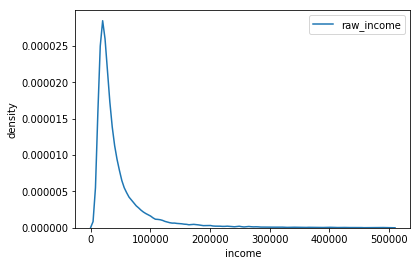

In [144]:


ax = sns.kdeplot(y_raw.values.reshape((len(y_train), 1))[:,0], label='raw_income')
#ax = sns.kdeplot(y_train, label='income')
ax.set(xlabel='income', ylabel='density')
plt.legend()

C:\Users\phiratath.n\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


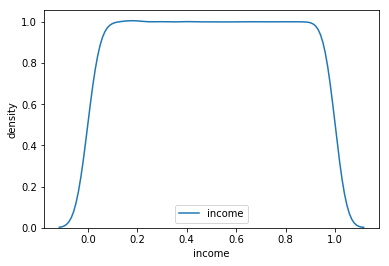

In [145]:
#ax = sns.kdeplot(y_raw, label='raw_income')
ax = sns.kdeplot(y_train, label='income')
ax.set(xlabel='income', ylabel='density')
plt.legend()

In [146]:
lgb_train = lgb.Dataset(X_train,y_train,free_raw_data=False)
lgb_eval = lgb.Dataset(X_val, y_val,free_raw_data=False, reference=lgb_train)

In [147]:
gbm = lgb.train(model_params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                feval= techjam_feval_quantile,
                verbose_eval=50,
                early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 0.212281	valid_0's techjam_score: 91.1147
[100]	valid_0's mape: 0.195338	valid_0's techjam_score: 91.9138
[150]	valid_0's mape: 0.187178	valid_0's techjam_score: 92.2689
[200]	valid_0's mape: 0.183162	valid_0's techjam_score: 92.4083
[250]	valid_0's mape: 0.181077	valid_0's techjam_score: 92.4608
[300]	valid_0's mape: 0.179962	valid_0's techjam_score: 92.4627
Early stopping, best iteration is:
[276]	valid_0's mape: 0.180438	valid_0's techjam_score: 92.4662


In [148]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred = qt.inverse_transform(y_pred.reshape((len(y_pred), 1)))[:,0]

In [149]:
X_test['pred'] = y_pred

C:\Users\phiratath.n\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [150]:
pred_score_list.append(y_pred)

In [151]:
techjam_score(X_test['pred'],y_test['income'])

92.27593207725383

In [152]:
#### Clip Target

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, (y), test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train.clip(upper=np.percentile(y_train,95),lower=np.percentile(y_train,5)), test_size=0.2, random_state=42)

In [154]:
lgb_train = lgb.Dataset(X_train,y_train,free_raw_data=False)
lgb_eval = lgb.Dataset(X_val, y_val,free_raw_data=False, reference=lgb_train)

In [155]:
gbm = lgb.train(model_params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                feval= techjam_feval_no_log,
                verbose_eval=50,
                early_stopping_rounds=50)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's mape: 0.388875	valid_0's techjam_score: 89.9837
[100]	valid_0's mape: 0.373865	valid_0's techjam_score: 90.9595
[150]	valid_0's mape: 0.365692	valid_0's techjam_score: 91.5177
[200]	valid_0's mape: 0.360425	valid_0's techjam_score: 91.9096
[250]	valid_0's mape: 0.357472	valid_0's techjam_score: 92.1444
[300]	valid_0's mape: 0.355728	valid_0's techjam_score: 92.299
[350]	valid_0's mape: 0.354754	valid_0's techjam_score: 92.3985
[400]	valid_0's mape: 0.354117	valid_0's techjam_score: 92.4759
[450]	valid_0's mape: 0.353721	valid_0's techjam_score: 92.5397
[500]	valid_0's mape: 0.353497	valid_0's techjam_score: 92.5884
[550]	valid_0's mape: 0.353367	valid_0's techjam_score: 92.6314
[600]	valid_0's mape: 0.353289	valid_0's techjam_score: 92.6688
[650]	valid_0's mape: 0.353214	valid_0's techjam_score: 92.7009
[700]	valid_0's mape: 0.353155	valid_0's techjam_score: 92.7244
[750]	valid_0's mape: 0.353196	valid_0's tech

In [156]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [157]:
X_test['pred'] = y_pred

C:\Users\phiratath.n\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [158]:
techjam_score(X_test['pred'],y_test['income'])

91.63595838629361

In [159]:
pred_score_list.append(y_pred)

# Predict Distribution 

In [160]:
bin_df  = pd.DataFrame(y_test)
for i in range(5):
    bin_df.loc[(bin_df['income'] > 20000*i)&(bin_df['income'] <= 20000*(i+1)),'bin']=i
    if i==4:
        bin_df.loc[(bin_df['income'] > 100000),'bin']=i

C:\Users\phiratath.n\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


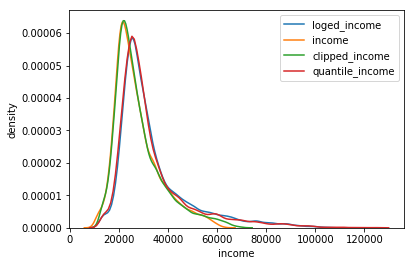

In [161]:
ax = sns.kdeplot(pred_score_list[0], label='loged_income')
ax = sns.kdeplot(pred_score_list[1], label='income')
ax = sns.kdeplot(pred_score_list[-1], label='clipped_income')
ax = sns.kdeplot(pred_score_list[2], label='quantile_income')
ax.set(xlabel='income', ylabel='density')
plt.legend()

In [162]:
bin_df['loged_income']=pred_score_list[0]
bin_df['raw_income']=pred_score_list[1]
bin_df['clipped_income']=pred_score_list[3]
bin_df['quantile_income']=pred_score_list[2]

In [163]:
bin_df.head()

,income,bin,loged_income,raw_income,clipped_income,quantile_income
id,,,,,,
33554,72000.0,3.0,56011.912599,40597.516939,40263.711421,56000.0
9428,53000.0,2.0,25631.834859,17937.363597,18894.911663,27000.0
200,19000.0,0.0,22324.826111,19225.134107,19602.715812,22000.0
12448,22000.0,1.0,25396.686309,19986.801052,19998.494584,26000.0
39490,24000.0,1.0,21497.859784,17565.043248,17994.476844,20000.0


In [164]:
y_test =bin_df['income'].values

In [165]:
score_summary = pd.DataFrame(bin_df.apply(lambda x:techjam_score(x,y_test)),columns=['techjam_score'])

In [166]:
score_summary.iloc[2:,:]

,techjam_score
loged_income,92.239963
raw_income,91.493528
clipped_income,91.635958
quantile_income,92.275932


In [167]:
df_log=pd.DataFrame(bin_df.groupby('bin').apply(lambda x: techjam_score(x['loged_income'],x['income'])))
df_raw=pd.DataFrame(bin_df.groupby('bin').apply(lambda x: techjam_score(x['raw_income'],x['income'])))
df_clip=pd.DataFrame(bin_df.groupby('bin').apply(lambda x: techjam_score(x['clipped_income'],x['income'])))
df_quantile=pd.DataFrame(bin_df.groupby('bin').apply(lambda x: techjam_score(x['quantile_income'],x['income'])))
bin_summary = pd.concat([df_raw,df_clip,df_log,df_quantile],axis=1)

In [168]:
bin_summary.columns = ['raw_income','clipped_income','loged_income','quantile_income']

In [169]:
bin_summary['income bin'] = ['0-20,000','20,000-40,000','40,000-60,000','60,000-80,000','100,000+']

In [170]:
bin_summary

,raw_income,clipped_income,loged_income,quantile_income,income bin
bin,,,,,
0.0,95.310972,94.906782,90.333004,90.971930,"0-20,000"
1.0,98.038220,98.074005,98.069536,98.137271,"20,000-40,000"
2.0,92.292365,92.528112,95.105940,94.789582,"40,000-60,000"
3.0,86.161002,86.660274,91.077640,90.553254,"60,000-80,000"
4.0,65.962572,67.199394,75.473119,74.938327,"100,000+"


[Text(0,0,'0-20,000'),
 Text(0,0,'20,000-40,000'),
 Text(0,0,'40,000-60,000'),
 Text(0,0,'60,000-80,000'),
 Text(0,0,'100,000+')]

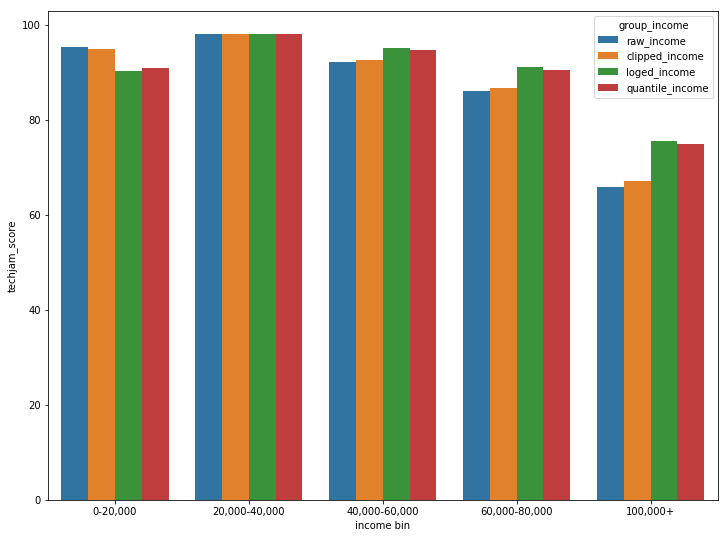

In [171]:
fig_dims = (12, 9)
data = bin_summary.melt('income bin', var_name='group_income', value_name='techjam_score')
fig, ax = plt.subplots(figsize=fig_dims)
ax=sns.barplot(x='income bin', y='techjam_score', hue='group_income', data=data)

ax.set_xticklabels(ax.get_xticklabels())